# Principal Component Analysis (PCA)
by Marc Deisenroth and Yicheng Luo

We will implement the PCA algorithm using the projection perspective. We will first implement PCA, then apply it to the MNIST digit dataset.

## Learning objectives
1. Write code that implements PCA.
2. Write code that implements PCA for high-dimensional datasets

Let's first import the packages we need for this week.

In [1]:
# PACKAGE: DO NOT EDIT THIS CELL
import numpy as np
import timeit
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from ipywidgets import interact
from sklearn.datasets import fetch_mldata

In [2]:
# PACKAGE: DO NOT EDIT THIS CELL
from sklearn.datasets import fetch_openml
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
%matplotlib inline

Now, let's plot a digit from the dataset:

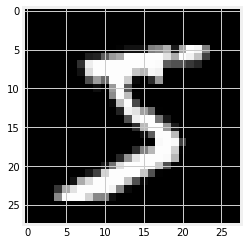

In [4]:
plt.figure(figsize=(4,4))
plt.imshow(images[0].reshape(28,28), cmap='gray');

Before we implement PCA, we will need to do some data preprocessing. In this assessment, some of them 
will be implemented by you, others we will take care of. However, when you are working on real world problems, you will need to do all these steps by yourself.

The preprocessing steps we will do are
1. Convert unsigned interger 8 (uint8) encoding of pixels to a floating point number between 0 and 1.
2. Subtract from each image the mean $\boldsymbol \mu$.
3. Scale each dimension of each image by $\frac{1}{\sigma}$ where $\sigma$ is the stardard deviation.

The steps above ensure that our images will have zero mean and one variance. These preprocessing
steps are also known as [Data Normalization or Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling).

## 1. PCA

Now we will implement PCA. Before we do that, let's pause for a moment and
think about the steps for performing PCA. Assume that we are performing PCA on
some dataset $\boldsymbol X$ for $M$ principal components. 
We then need to perform the following steps, which we break into parts:

1. Data normalization (`normalize`).
2. Find eigenvalues and corresponding eigenvectors for the covariance matrix $S$.
   Sort by the largest eigenvalues and the corresponding eigenvectors (`eig`).

After these steps, we can then compute the projection and reconstruction of the data onto the spaced spanned by the top $n$ eigenvectors.

1. [Sebastian Book Code](https://sebastianraschka.com/Articles/2015_pca_in_3_steps.html)

1. [Stack Overflow - Explanation](https://stats.stackexchange.com/questions/38835/clear-description-of-pca-using-svd-of-covariance-matrix?rq=1)  
1. [Stack Overflow - Explanation](https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com)
1. [Anothe code](https://glowingpython.blogspot.com/2011/07/pca-and-image-compression-with-numpy.html)  
Code not giving correct answer.

In [9]:
def normalize(X):
    """Normalize the given dataset X
    Args:
        X: ndarray, dataset
    
    Returns:
        (Xbar, mean, std): tuple of ndarray, Xbar is the normalized dataset
        with mean 0 and standard deviation 1; mean and std are the 
        mean and standard deviation respectively.
    
    Note:
        You will encounter dimensions where the standard deviation is
        zero, for those when you do normalization the normalized data
        will be NaN. Handle this by setting using `std = 1` for those 
        dimensions when doing normalization.
    """
    mu = np.mean(X, axis=0) # <-- EDIT THIS, compute the mean of X
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1
    Xbar = (X - mu)/std_filled  # <-- EDIT THIS, compute the normalized data Xbar
    return Xbar, mu, std

def eig(S):
    """Compute the eigenvalues and corresponding eigenvectors 
        for the covariance matrix S.
    Args:
        S: ndarray, covariance matrix
    
    Returns:
        (eigvals, eigvecs): ndarray, the eigenvalues and eigenvectors

    Note:
        the eigenvals and eigenvecs should be sorted in descending
        order of the eigen values
    """
    eig_vals, eig_vecs = np.linalg.eig(S)
    eigval_sorted_idx = np.argsort(eig_vals) # Index of sorted array 
    eigval_sorted_idx_max_first = np.sort(eigval_sorted_idx)[::-1] # Sorted index descending
    eig_vals_sorted = eig_vals[[eigval_sorted_idx_max_first]]
    eig_vecs_sorted = np.take(eig_vecs, eigval_sorted_idx_max_first, axis=1)
    #eig_vecs_sorted = (eig_vecs.T[[eigval_sorted_idx_max_first]]).T.copy() #same as above
    return (eig_vals_sorted, eig_vecs_sorted) # <-- EDIT THIS to return the eigenvalues and corresponding eigenvectors

def projection_matrix(B, num_components):
    """Compute the projection matrix onto the space spanned by `B`
    Args:
        B: ndarray of dimension (D, M), the basis for the subspace
    
    Returns:
        P: the projection matrix , a matrix of our concatenated top k eigenvectors.
    """
    if num_components  <= B.shape[-1]: #Cannot have num_components greater than size of eigenvectors
        P = B[:, :num_components]
    else: P = B

    return P # <-- EDIT THIS to compute the projection matrix

def PCA(X, num_components):
    """
    Args:
        X: ndarray of size (N, D), where D is the dimension of the data,
           and N is the number of datapoints
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: ndarray of the reconstruction
        of X from the first `num_components` principal components.
    """ 
    cov_mat = np.cov(X.T) # Compute the covariance matrix (D,D)
    eig_val, eig_vec = eig(cov_mat) # Compute the eigval (D,) & eigvec (D,D) with sorted components
    P = projection_matrix(eig_vec, num_components) # (D, num_components )
    
    X_compressed = X@P # (N, num_components) 
    X_reconstruct = X_compressed @ P.T # (N, D)
    #X = (eig_vec@np.diag(eig_val)[:, :num_components])@np.linalg.inv(eig_vec)
    
    # your solution should take advantage of the functions you have implemented above.
    return X_reconstruct # <--EDIT THIS to return the reconstruction of X



In [10]:
## Some preprocessing of the data
NUM_DATAPOINTS = 1000
X = (images.reshape(-1, 28 * 28)[:NUM_DATAPOINTS])/ 255.
Xbar, mu, std = normalize(X)

In [ ]:
for num_component in range(5, 20):
    from sklearn.decomposition import PCA as SKPCA
    # We can compute a standard solution given by scikit-learn's implementation of PCA
    pca = SKPCA(n_components=num_component, svd_solver='full')
    sklearn_reconst = pca.inverse_transform(pca.fit_transform(Xbar))
    reconst = PCA(Xbar, num_component)
    np.testing.assert_almost_equal(reconst, sklearn_reconst)
    print(np.square(reconst - sklearn_reconst).sum())

The greater number of of principal components we use, the smaller will our reconstruction
error be. Now, let's answer the following question: 


> How many principal components do we need
> in order to reach a Mean Squared Error (MSE) of less than $100$ for our dataset?



We have provided a function in the next cell that computes the mean squared error (MSE), which will be useful for answering the question above.

In [ ]:
def mse(predict, actual):
    """Helper function for computing the mean squared error (MSE)"""
    return np.square(predict - actual).sum(axis=1).mean()

In [ ]:
loss = []
reconstructions = []
# iterate over different numbers of principal components, and compute the MSE
for num_component in range(1, 100):
    reconst = PCA(Xbar, num_component)
    error = mse(reconst, Xbar)
    reconstructions.append(reconst)
    # print('n = {:d}, reconstruction_error = {:f}'.format(num_component, error))
    loss.append((num_component, error))

reconstructions = np.asarray(reconstructions)
reconstructions = reconstructions * std + mu # "unnormalize" the reconstructed image
loss = np.asarray(loss)

In [ ]:
import pandas as pd
# create a table showing the number of principal components and MSE
pd.DataFrame(loss).head()

We can also put these numbers into perspective by plotting them.

In [ ]:
fig, ax = plt.subplots()
ax.plot(loss[:,0], loss[:,1]);
ax.axhline(100, linestyle='--', color='r', linewidth=2)
ax.xaxis.set_ticks(np.arange(1, 100, 5));
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');

But _numbers dont't tell us everything_! Just what does it mean _qualitatively_ for the loss to decrease from around
$450.0$ to less than $100.0$?

Let's find out! In the next cell, we draw the the leftmost image is the original dight. Then we show the reconstruction of the image on the right, in descending number of principal components used.

In [ ]:
@interact(image_idx=(0, 1000))
def show_num_components_reconst(image_idx):
    fig, ax = plt.subplots(figsize=(20., 20.))
    actual = X[image_idx]
    # concatenate the actual and reconstructed images as large image before plotting it
    x = np.concatenate([actual[np.newaxis, :], reconstructions[:, image_idx]])
    ax.imshow(np.hstack(x.reshape(-1, 28, 28)[np.arange(10)]),
              cmap='gray');
    ax.axvline(28, color='orange', linewidth=2)

We can also browse throught the reconstructions for other digits. Once again, `interact` becomes handy for visualing the reconstruction.

In [ ]:
@interact(i=(0, 10))
def show_pca_digits(i=1):
    """Show the i th digit and its reconstruction"""
    plt.figure(figsize=(4,4))
    actual_sample = X[i].reshape(28,28)
    reconst_sample = (reconst[i, :] * std + mu).reshape(28, 28)
    plt.imshow(np.hstack([actual_sample, reconst_sample]), cmap='gray')
    plt.show()